In [1]:
import sys

In [2]:
sys.path.append('/home/p/reFUEL/syfop/')

In [3]:
import pathlib
import xarray as xr

In [4]:
import syfop

In [5]:
from syfop.util import *
from syfop.node import *
from syfop.network import *

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/home/p/HiGHS/build/bin"
os.environ['GRB_LICENSE_FILE'] = '/opt/gurobi810/gurobi.lic'

## Parameters

In [8]:
battery_cost = 33             # EUR/KWh/a
hydrogen_storage_cost = 74    # EUR/kg/a
co2_storage_cost = 0.049      # EUR/kg/a

electrolizer_cost = 30        # kW/a
pv_cost = 53                  # EUR/kW/a
wind_cost = 128               # EUR/kW/a

electrolizer_efficiency_multiplier = 1
# electrolizer_efficiency = 0.63 * electrolizer_efficiency_multiplier
# 0.63 is the value for energy -> energy, if h2 is measured in tons, we use 0.019 according to Jo:
#     der wert von 0.019 entspricht einer effizienz von 0.63
#     wenn wir 0.69 rechnen wollen, multiplizieren wir 0.019 mit 069/0.63
#     1 KWh electricty * 0.019 = 1 kg H2
#
# 1kg_h2 = 33kWh, zur Herstellung: 1kg_h2 = 33/0.63kWh = 1/0.019 kWh
# --> 1 kWh = 0.019kg_h2
electrolizer_convert_factor = 0.019 * 1e-3  # 1KWh --> 1 ton h2

# -- below here probably constant for all scenarios

methanol_synthesis_cost = 42.  # in EUR/KW/a - taken from result csv


balanceCO2H2 = 7.268519  # from gams file
# balanceCO2H2 * h2 = co2
# --> balanceCO2H2 * h2 + h2 = co2 + h2
# --> (balanceCO2H2 + 1) * h2 = co2 + h2
# --> h2 / (co2 + h2) = 1/(balanceCO2H2 + 1)
methanol_synthesis_input_proportions = {"co2": 1 - 1/(balanceCO2H2 + 1), "electrolizer": 1/(balanceCO2H2 + 1)}

methanolSysnthesisEff = 5.093 * 5.54 * 1e3
methanol_synthesis_convert_factor = 1/(balanceCO2H2 + 1) * methanolSysnthesisEff

storage_params = {
    'electricity':{
        'costs': battery_cost,
        'max_charging_speed': 0.4,   # taken from GAMS file (value from Jo)
        'storage_loss': 0.01,        # 0.99 from GAMS file
        'charging_loss': 0.1,        # 0.9 in gdx and result file
    },
    'co2': {
        'costs': 1e3 * co2_storage_cost,
        'max_charging_speed': 0.2,   # taken from GAMS file (value from Jo)
        'storage_loss': 0,
        'charging_loss': 0,
    },
    'hydrogen': {
        'costs': 1e3 * hydrogen_storage_cost,
        'max_charging_speed': 0.2,   # taken from GAMS file (value from Jo)
        'storage_loss': 0,
        'charging_loss': 0,
    },
}

## Read input data

In [9]:
DATA_DIR = pathlib.Path('..') / 'reproduce-brazil-paper' / 'land-neutral-renewable-fuels'

In [10]:
INPUT_DATA = DATA_DIR / 'input-data'

In [11]:
ethanol_plants = pd.read_csv(INPUT_DATA / 'ethanol-plants-brazil' / 'eth_consolidated_installations_and_statistics.csv')

In [12]:
# the location_id is a number between 0 and 338, epe_id is the ID of the epe data source (between 0
# and 380, but not all locations of the epe data source are used)
# epe_id = ethanol_plants.original_index_epe[location_id]
epe_id = 11

In [13]:
solar_pv_input_profile = xr.load_dataset(INPUT_DATA / 'pv-simulation' / 'pv_BRA_ERA5_land.nc')
# note that 2016 is a leap year, so we skip the 31st of December because we use CO2 data from 2017 and need equal lengths
solar_pv_input_profile = solar_pv_input_profile.pv.sel(epe_id=epe_id,time=slice('2016-01-01', '2016-12-30'))

# PV time series are given in KW for a PV plant with 1MW capacity
# That means deviding by 1e3 gives us capacity factors:
solar_pv_input_profile = solar_pv_input_profile * 1e-3

In [14]:
# make sure that we have capacity factors
assert (0 <= solar_pv_input_profile).all() and (solar_pv_input_profile <= 1).all()

In [15]:
wind_class2_input_flow = xr.load_dataset(INPUT_DATA / 'windpower-ethanol' / 'windpower_BRA_ERA5_GWA2_iecII.nc')
# note that 2016 is a leap year, so we skip the 31st of December because we use CO2 data from 2017 and need equal lengths
wind_class2_input_flow = wind_class2_input_flow.sel(epe_id=epe_id,time=slice('2016-01-01', '2016-12-30')).wp

# for wind class 2 a 2000KW turbine has been used, so we devide by 2000 to get capacity factors
# see: land-neutral-renewable-fuels/input-data/techno-economic-parameters/windturbines.csv
wind_class2_input_profile = wind_class2_input_flow / 2000

In [16]:
wind_class3_input_flow = xr.load_dataset(INPUT_DATA / 'windpower-ethanol' / 'windpower_BRA_ERA5_GWA2_iecIII.nc')
# note that 2016 is a leap year, so we skip the 31st of December because we use CO2 data from 2017 and need equal lengths
wind_class3_input_flow = wind_class3_input_flow.sel(epe_id=epe_id,time=slice('2016-01-01', '2016-12-30')).wp

# for wind class 3 a 3150KW turbine has been used, so we devide by 3150 to get capacity factors
# see: land-neutral-renewable-fuels/input-data/techno-economic-parameters/windturbines.csv
wind_class3_input_profile = wind_class3_input_flow / 3150

In [17]:
# unit = tons
co2_input_flow = pd.read_csv(INPUT_DATA / 'ethanol-plants-brazil' / 'generated_e_demand_time_series' / str(epe_id), parse_dates=['Unnamed: 0'])
co2_input_flow = xr.DataArray(co2_input_flow.CO2, coords={'time': co2_input_flow['Unnamed: 0']})
co2_input_flow = co2_input_flow.isel(time=slice(None, -1))  # exclude 1st January 2018

In [18]:
co2_input_flow['time'] = solar_pv_input_profile.time

## Result file from the Brazil paper

In [19]:
# Units in the result file according to Jo:

# alles was kapazität: GW (strom)
# alles was energie: GWh (strom, methanol)
# alles was co2 oder h2: kilotons (co2, h2)
# alles was total costs ist: million euro (costs)
# alles was unit costs ist: ansich eh input parameter, aber ist dann in mill euro pro unit wie oben

In [20]:
# according to Johannes, this is the right file to look at (PV is enabled)
fname_result = DATA_DIR / 'results' / 'revisions2-runs-main-pv-manuscript.csv'
result = pd.read_csv(fname_result)

In [21]:
scenario_set = 'revisions2-runs-main-pv-manuscript'

In [22]:
scenario = f'bat_{battery_cost}-elyzerc_{electrolizer_cost}-h2storc_{hydrogen_storage_cost}-co2storc_{co2_storage_cost}-pvc{pv_cost}-windc{wind_cost}-eyzereffmult_{electrolizer_efficiency_multiplier}'

In [23]:
len(result[(result.scenario == scenario)])

339

In [24]:
len(result[(result['storageCost.co2'] == co2_storage_cost)
       & (result.electrolizerCost == electrolizer_cost)
       & (result['storageCost.electricity'] == battery_cost)
       & (result['storageCost.h2'] == hydrogen_storage_cost)
       & (result['cost.PV.tech1'] == pv_cost)
       & (result['increaseElectrolyzerEfficiency'] == electrolizer_efficiency_multiplier)
])

339

In [25]:
result[(result.scenario == scenario) & (result.epe_id == epe_id)].T

,685
epe_id,11
x_electrolizerSize,0.027181
x_methanolSynthesisSize,0.012179
modelstatus,1.0
solvestatus,1.0
x_cost,6.1158
electrolizerCost,30.0
methanolSynthesisCost,42.0
co2UseProportion,1.0
increaseElectrolyzerEfficiency,1.0


## Why is wind attractive at all?

In [26]:
import matplotlib.pyplot as plt

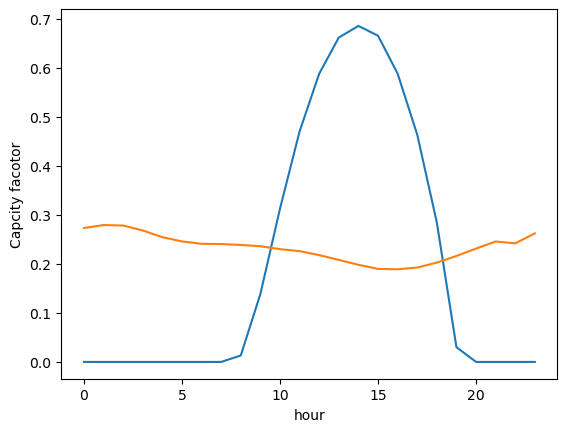

In [27]:
solar_pv_input_profile.groupby(solar_input_profile.time.dt.hour).mean().plot()
wind_class2_input_profile.groupby(solar_input_profile.time.dt.hour).mean().plot()
plt.ylabel('Capcity facotor')
plt.title('');

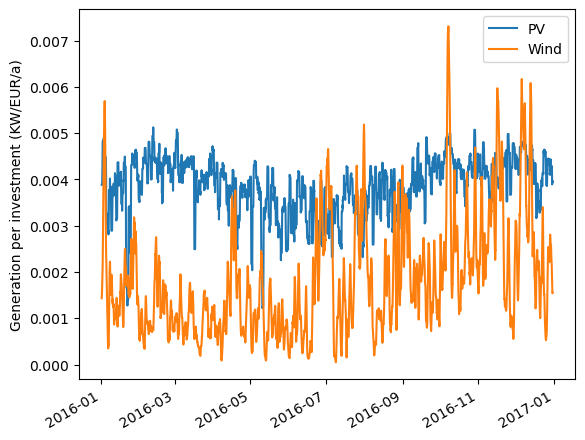

In [28]:
(solar_pv_input_profile / pv_cost).rolling(time=24).mean().plot(label='PV')
(wind_class2_input_profile / wind_cost).rolling(time=24).mean().plot(label='Wind')
plt.xlabel('')
plt.legend()
plt.ylabel('Generation per investment (KW/EUR/a)')
plt.title('');

## Model

In [29]:
# note: for now we don't distinguish between KW and KWh (per time stamp), this is okayish since we have hourly time stamps

solar_pv = NodeScalableInput(
    name="solar_pv",
    input_profile=solar_pv_input_profile,
    costs=pv_cost,
)
wind_class2 = NodeScalableInput(
    name="wind_class2",
    input_profile=wind_class2_input_profileile,
    costs=wind_cost,
)
wind_class3 = NodeScalableInput(
    name="wind_class3",
    input_profileile=wind_class3_input_profile,
    costs=wind_cost,
)
co2 = NodeFixInput(
    name="co2",
    costs=0,
    input_flow=co2_input_flow,
    storage=Storage(**storage_params['co2']),
)
electricity = Node(
    name="electricity",
    inputs=[solar_pv, wind_class2, wind_class3],
    input_commodities="electricity",
    costs=0,
    storage=Storage(**storage_params['electricity']),
)
curtail_electricity = Node(
    name="curtail_electricity",
    inputs=[electricity],
    input_commodities="electricity",
    costs=0,
)
electrolizer = Node(
    name="electrolizer",
    inputs=[electricity],
    input_commodities="electricity",
    costs=1/electrolizer_convert_factor * electrolizer_cost,
    convert_factor=electrolizer_convert_factor,
    storage=Storage(**storage_params['hydrogen']),
)

methanol_synthesis = Node(
    name="methanol_synthesis",
    inputs=[co2, electrolizer],
    input_commodities=["co2", "hydrogen"],
    costs=methanol_synthesis_cost,
    convert_factor=methanol_synthesis_convert_factor,
    input_proportions=methanol_synthesis_input_proportions,
)

network = Network(
    [
        solar_pv,
        wind_class2,
        wind_class3,
        electricity,
        curtail_electricity,
        electrolizer,
        co2,
        methanol_synthesis,
    ],
    time_coords=solar_pv_input_profile.time,
)

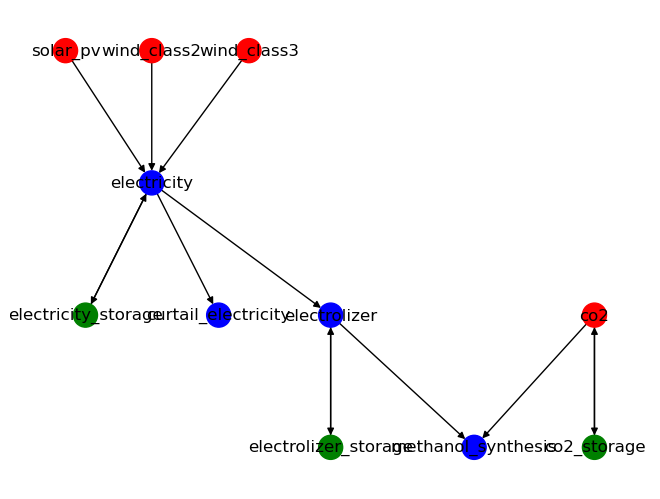

In [30]:
network.draw()

In [31]:
# this adds two constraints which are used in the Brazil paper too implicitely
end_brazil_paper = co2_input_flow.time.isel(time=(co2_input_flow - co2_input_flow.mean()).cumsum().argmin()).values
network.model.add_constraints(network.nodes_dict['co2'].storage.level.sel(time=end_brazil_paper) == 0)
network.model.add_constraints(network.nodes_dict['electrolizer'].storage.level.sel(time=end_brazil_paper) == 0)

Constraint `con1`
-----------------
1.0 storage_level_electrolizer[2016-09-23 00:00:00] = 0

In [32]:
network.optimize('gurobi')

Set parameter Username
Academic license - for non-commercial use only - expires 2023-12-01
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 236522 rows, 157688 columns and 608384 nonzeros
Model fingerprint: 0x27098ed1
Coefficient statistics:
  Matrix range     [2e-05, 3e+03]
  Objective range  [3e+01, 2e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 5e+00]
Presolve removed 104135 rows and 77853 columns
Presolve time: 1.37s
Presolved: 49183 rows, 137637 columns, 564795 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 Free vars  : 320
 AA' NZ     : 3.998e+05
 Factor NZ  : 1.039e+06 (roughly 80 MB of memory)
 Factor Ops : 2.528e+07 (less than 1 second per iteration)
 Threads    : 3

              

    6230 PPushes remaining with PInf 0.0000000e+00                21s
       0 PPushes remaining with PInf 0.0000000e+00                22s

  Push phase complete: Pinf 0.0000000e+00, Dinf 1.4044040e-09     22s


Solved with barrier
Iteration    Objective       Primal Inf.    Dual Inf.      Time
   49004    6.1158002e+06   0.000000e+00   0.000000e+00     22s

Solved in 49004 iterations and 22.49 seconds (31.57 work units)
Optimal objective  6.115800196e+06
Solving time:  27.282362461090088


## Compare CO2 storage level to Brazil paper

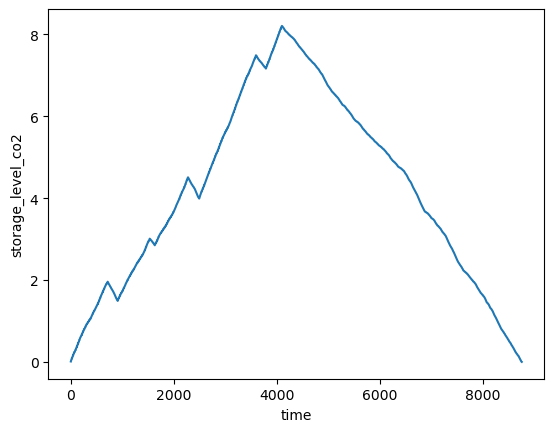

In [33]:
# this file is from the GDX file on nora
out = xr.load_dataset('../reproduce-brazil-paper/out11.nc')
out.storage_level_co2.plot()

In [34]:
idx = (co2_input_flow - co2_input_flow.mean()).cumsum().argmin() + 1
start_brazil_paper = co2_input_flow.time.isel(time=idx).values

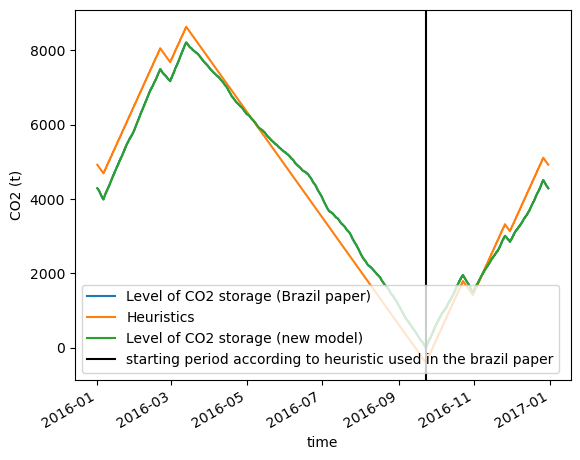

In [35]:
plt.plot(network.model.solution.storage_level_co2.time, 1e3 * out.storage_level_co2.roll(time=idx.values).values, label='Level of CO2 storage (Brazil paper)')

((co2_input_flow - co2_input_flow.mean()).cumsum() - ((co2_input_flow - co2_input_flow.mean()).cumsum() - network.model.solution.storage_level_co2).mean()).plot(label='Heuristics')

network.model.solution.storage_level_co2.plot(label='Level of CO2 storage (new model)')
idx = (co2_input_flow - co2_input_flow.mean()).cumsum().argmin() + 1
start_brazil_paper = co2_input_flow.time.isel(time=idx).values
plt.axvline(
    start_brazil_paper, color='k',
    label='starting period according to heuristic used in the brazil paper'
)
plt.ylabel('CO2 (t)')
plt.legend();

In [36]:
network.model.solution.storage_level_electrolizer.sel(time=end_brazil_paper)

<xarray.DataArray 'storage_level_electrolizer' ()>
array(0.)
Coordinates:
    time     datetime64[ns] 2016-09-23

In [37]:
out.storage_level_electrolizer[-1]

<xarray.DataArray 'storage_level_electrolizer' ()>
array(0.)
Coordinates:
    time     int64 8760

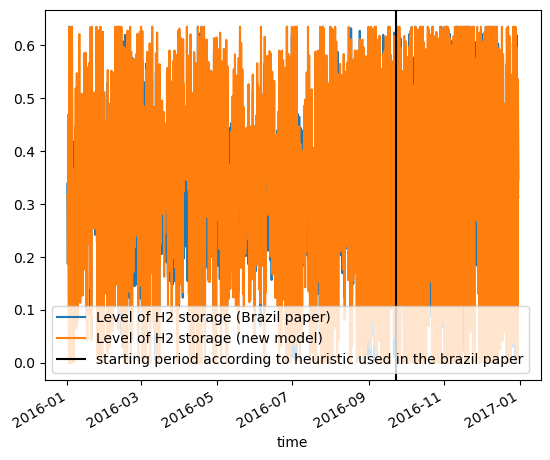

In [38]:
plt.plot(network.model.solution.storage_level_electrolizer.time, 1e3 * out.storage_level_electrolizer.roll(time=idx.values).values, label='Level of H2 storage (Brazil paper)')
network.model.solution.storage_level_electrolizer.plot(label='Level of H2 storage (new model)')

plt.axvline(
    start_brazil_paper, color='k',
    label='starting period according to heuristic used in the brazil paper'
)
plt.ylabel('')
plt.legend();

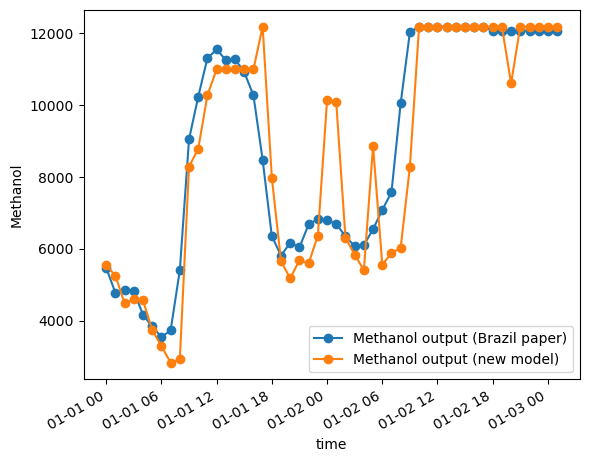

In [39]:
plt.plot(
    network.model.solution.flow_methanol_synthesis.time[:50],
    1e6 * out.flow_methanol_synthesis.roll(time=idx.values).values[:50],
    marker='o',
    label='Methanol output (Brazil paper)')

network.model.solution.flow_methanol_synthesis[:50].plot(
    marker='o',
    label='Methanol output (new model)',
)

#plt.axvline(
#    start_brazil_paper, color='k',
#    label='starting period according to heuristic used in the brazil paper'
#)
plt.ylabel('Methanol')
plt.legend();

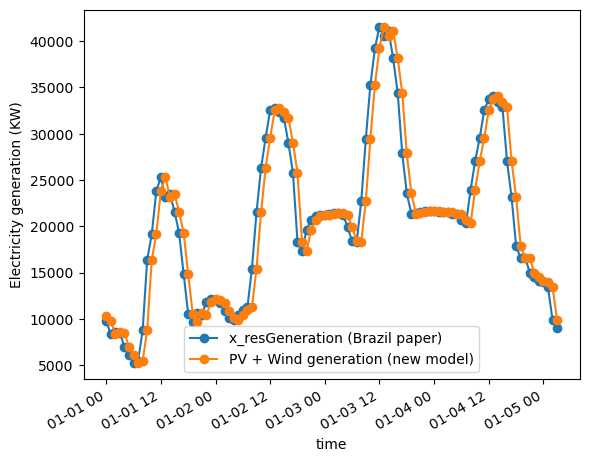

In [40]:
plt.plot(
    network.model.solution.flow_wind_class3_electricity.time[:100],
    1e6 * out.x_resGeneration.roll(time=idx.values).values[:100],
    marker='o',
    label='x_resGeneration (Brazil paper)')

(network.model.solution.flow_solar_pv_electricity + network.model.solution.flow_wind_class3_electricity)[:100].plot(
    marker='o',
    label='PV + Wind generation (new model)',
)

#plt.axvline(
#    start_brazil_paper, color='k',
#    label='starting period according to heuristic used in the brazil paper'
#)
plt.ylabel('Electricity generation (KW)')
plt.legend();

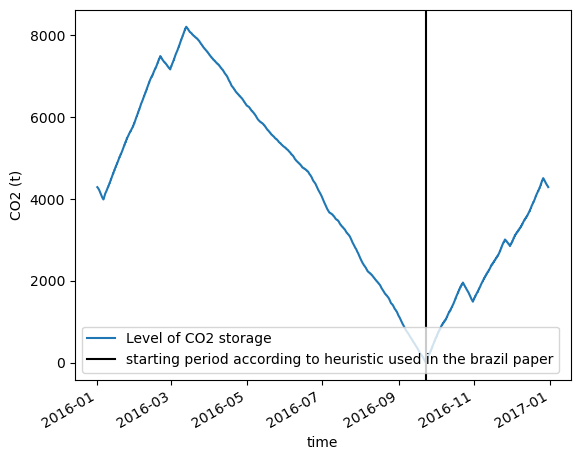

In [41]:
network.model.solution.storage_level_co2.plot(label='Level of CO2 storage')
plt.axvline(
    start_brazil_paper, color='k',
    label='starting period according to heuristic used in the brazil paper'
)
plt.ylabel('CO2 (t)')
plt.legend();

## Plot in/out flows

In [42]:
keys = [key for key in network.model.solution.variables.keys() if 'flow_' in key]

In [43]:
def plot_flow(i):
    network.model.solution[keys[i]][:100].plot()

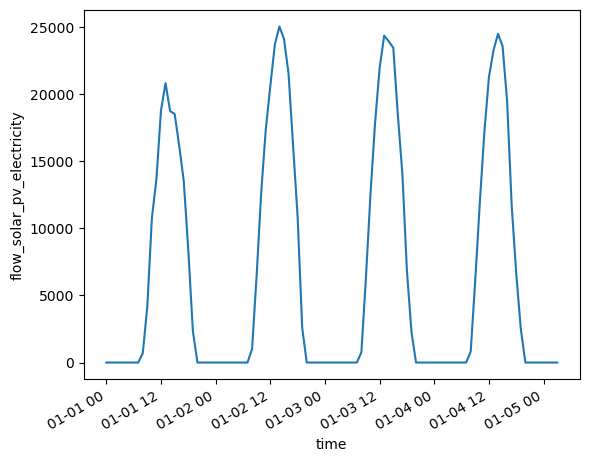

In [44]:
plot_flow(0)

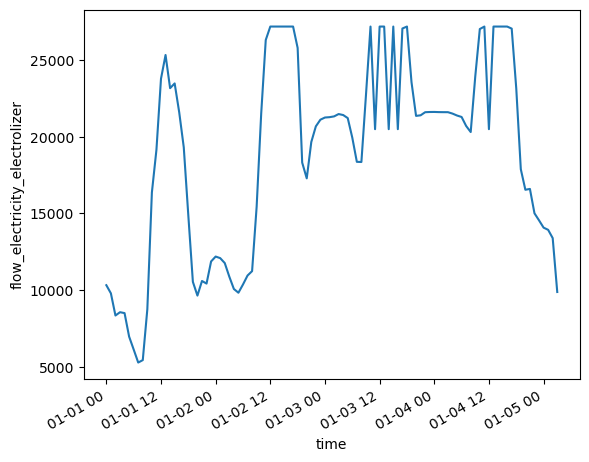

In [45]:
plot_flow(4)

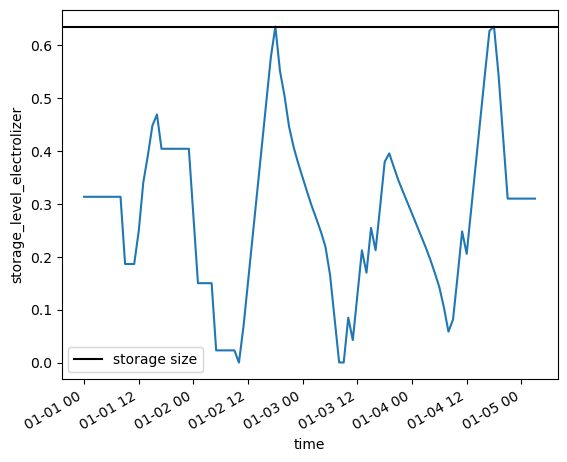

In [46]:
network.model.solution.storage_level_electrolizer[:100].plot()
plt.axhline(network.model.solution.size_storage_electrolizer, color='k', label='storage size')
plt.legend();

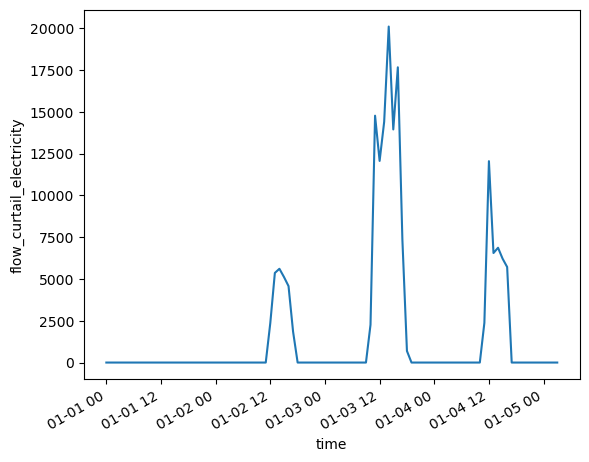

In [47]:
plot_flow(7)

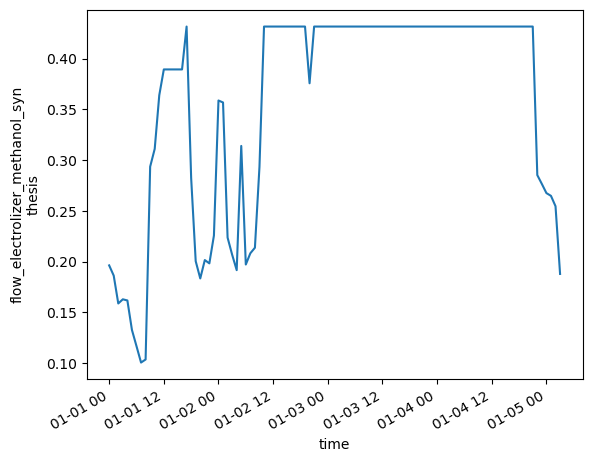

In [48]:
plot_flow(6)

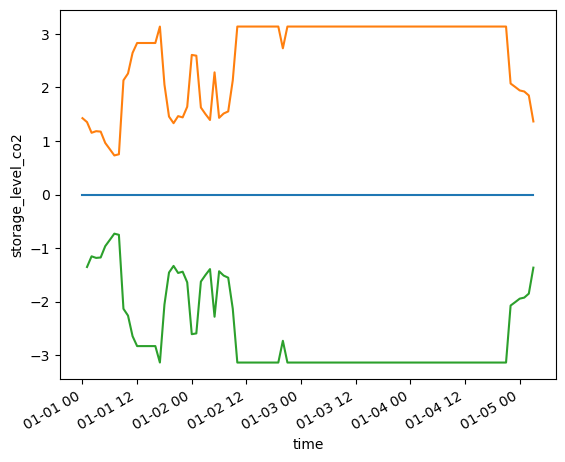

In [49]:
network.model.solution.storage_charge_co2[:100].plot()
network.model.solution.storage_discharge_co2[:100].plot()
network.model.solution.storage_level_co2[:100].diff(dim='time').plot()

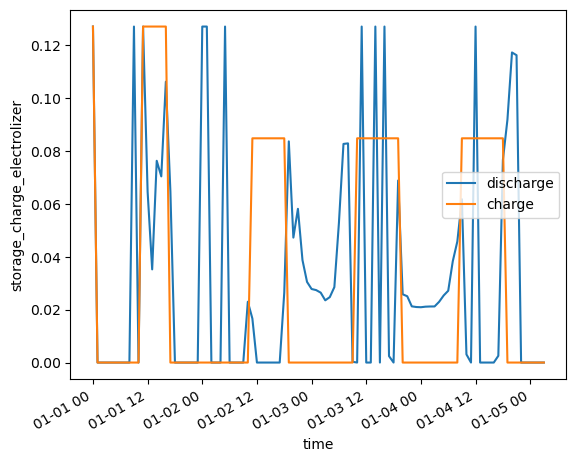

In [50]:
network.model.solution.storage_discharge_electrolizer[:100].plot(label='discharge')
network.model.solution.storage_charge_electrolizer[:100].plot(label='charge')
plt.legend();

## Compare results to Brazil paper

In [51]:
mapping = {
    'size_solar_pv': ('x_resBuild.PV.tech1', 'KW', 1e6),                    # KW / GW
    'size_wind_class2': ('x_resBuild.Wind.tech1', 'KW', 1e6),               # KW / GW
    'size_wind_class3': ('x_resBuild.Wind.tech2', 'KW', 1e6),               # KW / GW
    'size_storage_electricity': ('x_storageSize.electricity', 'KWh', 1e6),  # KWh / GWh
    'size_storage_electrolizer': ('x_storageSize.h2', 't', 1e3),            # t / kt
    'size_electrolizer': ('x_electrolizerSize', 't',
                          electrolizer_convert_factor * 1e6),               # t / GW
    'size_storage_co2': ('x_storageSize.co2', 't', 1e3),                    # t / kt
    'size_methanol_synthesis': ('x_methanolSynthesisSize', 'KW', 1e6),      # KW / GW
}

In [52]:
result_paper_scenario = result[(result.scenario == scenario) & (result.epe_id == epe_id)]

result_comparison = pd.DataFrame({f"{key_new} ({unit})":
    [
        network.model.solution[key_new].values,
        factor * result_paper_scenario[key_paper].iloc[0]
    ]
    for key_new, (key_paper, unit, factor) in mapping.items()}, index=('Syfop', 'Paper')).T

result_comparison.loc['total_costs (Mill EUR)'] = [
    network.model.objective.value * 1e-6,
    result_paper_scenario.x_cost.iloc[0]
]

result_comparison.loc['methanol_total (GWh / year)'] = [
    network.model.solution.flow_methanol_synthesis.sum().values * 1e-6,
    result_paper_scenario['methanol_total'].iloc[0]
]

result_comparison.loc['curtailment_total (GWh / year)'] = [
    network.model.solution.flow_electricity_curtail_electricity.sum().values * 1e-6,
    result_paper_scenario['curtailment_total'].iloc[0]
]

In [53]:
result_comparison['rel_error (%)'] = 100 * (result_comparison['Syfop'] / result_comparison['Paper'] - 1)

In [54]:
result_comparison

,Syfop,Paper,rel_error (%)
size_solar_pv (KW),29637.326249279857,29637.342548,-0.000055
size_wind_class2 (KW),0.0,0.0,NaN
size_wind_class3 (KW),21631.773968338886,21631.764718,0.000043
size_storage_electricity (KWh),0.0,0.0,NaN
size_storage_electrolizer (t),0.6353214018308252,0.635323,-0.000241
size_electrolizer (t),0.5164481876929539,0.516448,-0.000033
size_storage_co2 (t),8207.683768804289,8207.683884,-0.000001
size_methanol_synthesis (KW),12179.048599844427,12179.047149,0.000012
total_costs (Mill EUR),6.1158,6.1158,-0.000001
methanol_total (GWh / year),65.904098,65.904098,-0.0


### Manually check objective function

In [55]:
# reproduce syfop objective
(
    3.8745029798172026 * 1e3 * hydrogen_storage_cost +
    1.0427960080433525 * 1/electrolizer_convert_factor * electrolizer_cost + 
    6803.939679344654 * wind_cost +
    55578.148587953714 * pv_cost +
    8268.740884798834  * 1e3 * co2_storage_cost +
    11184.789813936339 * methanol_synthesis_cost
) * 1e-6

6.624708862864634

In [56]:
# reproduce paper objective
(
    0.635323 * 1e3 * hydrogen_storage_cost +
    0.516448 * 1/electrolizer_convert_factor * electrolizer_cost + 
    21631.764718 * wind_cost +
    29637.342548 * pv_cost +
    8207.683884  * 1e3 * co2_storage_cost +
    12179.047149 * methanol_synthesis_cost
) * 1e-6

6.115799642048316

Okay, this looks goog! Same values as in the objective given by the model.

### Electricity generation in the model

Used electric energy generation excluding curtailment in syfop:

In [57]:
float(network.model.solution.flow_electricity_electrolizer.sum() * 1e-6)

122.93495215682856

Used electric energy generation excluding curtailment in paper:

In [58]:
float(out.x_resGeneration.sum() - result_paper_scenario.curtailment_total.values[0])

123.04679834646866

Curtailment in syfop:

In [59]:
float(network.model.solution.flow_curtail_electricity.sum() * 1e-6)

4.758783642501065

Curtailment in paper:

In [60]:
result_paper_scenario.curtailment_total.values[0]

4.64294133381424

Total electric energy generation including curtailment in syfop:

In [61]:
float(network.model.solution.flow_curtail_electricity.sum() * 1e-6 + network.model.solution.flow_electricity_electrolizer.sum() * 1e-6)

127.69373579932963

Total electric energy generation including curtailment in paper:

In [62]:
float(out.x_resGeneration.sum())

127.6897396802829

## Debug the model by printing constraints

In [63]:
# constraints_as_str = constraints_to_str(network.model)